/home/cody/layer-distillation/data/train_32x32


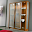

In [1]:
import tensorflow as tf
tf.__version__
AUTOTUNE = tf.data.experimental.AUTOTUNE

import pathlib

data_root = pathlib.Path('/home/cody/layer-distillation//data/train_32x32/')
print(data_root)

import random
all_image_paths = list(data_root.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

all_image_paths[:10]

import IPython.display as display

image_path = random.choice(all_image_paths)
display.display(display.Image(image_path))

all_image_labels = [0 for path in all_image_paths]

img_raw = tf.io.read_file(str(image_path))

In [2]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(32, 32, 3)
<dtype: 'uint8'>


In [29]:
def preprocess_image(image):
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, [32, 32])
    #image = tf.cast(image, tf.float32)
    image /= 255  # normalize to [0,1] range

    return image

In [30]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

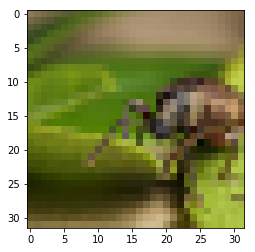

In [31]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
#plt.xlabel(caption_image(image_path))
#plt.title(label_names[label].title())
print()

In [32]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [33]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [34]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [35]:
image_ds

<ParallelMapDataset shapes: (32, 32, 3), types: tf.float32>

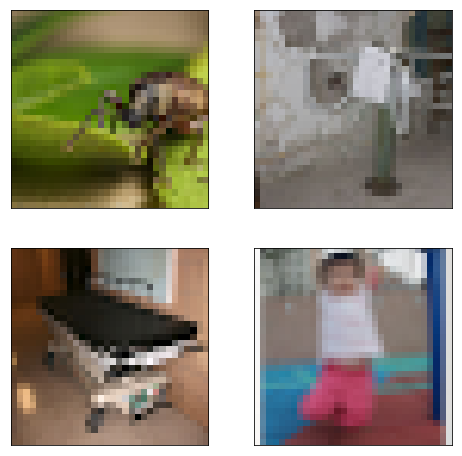

In [36]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])


In [37]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [38]:
for label in label_ds.take(10):
  print([label.numpy()])

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [39]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [40]:
print(image_label_ds)

<ZipDataset shapes: ((32, 32, 3), ()), types: (tf.float32, tf.int64)>


In [41]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>